[18-6-2020]

Note to self: I may create a Github repository for all codes that I have written for this project. [?]

[19-6-2020] 

Note to self: May make the code neater by trying to do something like: combining "gaus_noise_presence" and "subsampling_noise_presence" into "nature_of_noise", which can be tuned into "artificial_gaussian_noise" or "subsampling_noise".

Any other actions to do in this aspect of characterising the noise?

In [1]:
import numpy as np
import math
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import operator

# Highest Level SBPS algorithm

[16-6-2020]

Some of the steps that I have not implemented yet:
1. Suspicious step: gradient ascent after acceptance/rejection step
2. Introduction of auxiliary time


Moreover, I may need to add more outputs to SBPS for purposes such as diagnosing, etc.

[19-6-2020]

Catching an idea that I have:
Because your project is not just about “your invention of new SBPS algorithm” –- there are other technical details to learn such as all those experiments you need to run, I wonder whether I should just go with the current original SBPS algorithm that I invented. [?]

In [2]:
def SBPS(x0, v0, Time, lambda_ref, prob_dist, delta_t, k):
    
    # Need to ensure that euclidean norm of v0 equals 1.
    
    turn_pts = [x0]
    list_of_velo = [v0]
    striding_times = [0]
    dim = x0.size
    i = 1
    x = x0
    v = v0
    t = 0
    
    delta_U_tilde, G_tilde, c_t_squared, log_grad_list_0 = eval_G_tilde_plus_emp_var(x, v, prob_dist)
    next_array_of_obs = np.array([[0, G_tilde, c_t_squared]])    # time; G_tilde; variance
    
    
    while t < Time:
        
        tau_bounce, observed_grad, next_array_of_obs = bounce_time_local_linear_reg_paper_version(x, v, next_array_of_obs, 
                                                                                                  prob_dist, delta_t, k)
        beta = 1/lambda_ref
        tau_ref = np.random.exponential(scale = beta)
    
    
        tau = min(tau_bounce, tau_ref)
        x = x + tau*v
        t = t + tau
        
        
        if tau_ref < tau_bounce:
            unscaled_v = np.random.standard_normal(dim)
            v = unscaled_v / np.linalg.norm(unscaled_v)
        else:
            v = reflection(v, observed_grad)
            
        
        list_of_velo.append(v)
        turn_pts.append(x)
        striding_times.append(t)
        i = i+1


    return turn_pts, list_of_velo, striding_times     # [x_list, v_list, t_list]

       

Reflection of Velocity - Function

In [3]:
def reflection(v, observed_grad):
    
    return v - 2*(np.sum(observed_grad*v)/(np.sum(observed_grad*observed_grad)))*observed_grad


# Sampling Locations at arbitrary time

In [4]:

def x_v_t_arbitrary_times(turn_pts, list_of_velo, striding_times, intermediate_times):
    
    num_changes = len(turn_pts)
    num_required_times = len(intermediate_times)
    tiling_interm_times = np.transpose(np.tile(intermediate_times, (num_changes, 1)))
    testing_mat_1 = tiling_interm_times - np.tile(striding_times, (num_required_times, 1))
    testing_mat_2 = np.where(testing_mat_1 >= 0, 1, 0)
    indices_no_later_than = np.sum(testing_mat_2, axis = 1) - 1
        
    turn_pts_no_later = [turn_pts[i] for i in indices_no_later_than]
    velo_no_later = [list_of_velo[i] for i in indices_no_later_than]
    stride_time_no_later = [striding_times[i] for i in indices_no_later_than]
    
       
    interm_times = list(intermediate_times)
        
    list_of_coasting_times = list(map(operator.sub, interm_times, stride_time_no_later))
    distance_strided = list(map(operator.mul, list_of_coasting_times, velo_no_later))
    locations_at_required_times = list(map(operator.add, turn_pts_no_later, distance_strided))
        

    return locations_at_required_times, velo_no_later, interm_times


# Approximating Cox Process: Local Linear Regression Upper Bound

Another error discovered in Ari's algorithm: after a reflection of velocity, it seems that the empirical variance will change. Hence, I corrected it in this code. [?]

In [28]:

def bounce_time_local_linear_reg_paper_version(x, v, initialised_arr_of_obs, prob_dist, delta_t, k, 
                                               mu_0=0, sig_0=1, mu_1=0, sig_1=1):
    
    accepted = 0
    time_coasted = 0
    
    
    array_of_observations = initialised_arr_of_obs
    
    
    while accepted == 0:
        
        hat_beta_0, hat_beta_1, Sigma_cov_mat = Bayesian_Linear_Regression_doub_gaus(array_of_observations, 
                                                                                 sig_0, mu_0, sig_1, mu_1)
    
        start_time = array_of_observations[-1,0]
        extrapolated_var = array_of_observations[-1,2]
    
        proposed_time, upper_bound_intensity = adaptive_thinning_paper_version(start_time, hat_beta_0, hat_beta_1, 
                                                    Sigma_cov_mat, extrapolated_var, k, delta_t)
    
        time_coasted = proposed_time
    
        observed_grad, acc_rej_G, acc_reg_var, log_grad_list = eval_G_tilde_plus_emp_var(x + time_coasted*v, v, prob_dist)
    
        prob_of_acc = probability_of_acceptance(max(0, acc_rej_G), upper_bound_intensity)
    
        sampling_prob = np.random.uniform()
    
        if sampling_prob < prob_of_acc:
            accepted = 1
            
            if prob_dist.nature_of_noise == 'artificial_gaus':
                reinitialised_arr_of_obs = np.array([[0, -acc_rej_G, acc_reg_var]])
                
                
            if prob_dist.nature_of_noise == 'subsampling':
                
                reflected_v = reflection(v, observed_grad)
                reflected_dot_prods = log_grad_list.dot(reflected_v)
                reflected_var = (prob_dist.num_obs**2)*(1 - prob_dist.n/prob_dist.num_obs)*np.var(reflected_dot_prods)
                
                reinitialised_arr_of_obs = np.array([[0, -acc_rej_G, reflected_var]])
            
        else:
            new_obs = np.array([[time_coasted, acc_rej_G, acc_reg_var]])
            array_of_observations = np.concatenate((array_of_observations, new_obs), axis=0)
            
            

            
            
            
    # What I need to return (may not be exhaustive): tau_bounce, observed_gradient, 
    # the re-initialised list of observations [[0,-G(t),c_t]].
    
    return time_coasted, observed_grad, reinitialised_arr_of_obs

In the following function for calculating probability of acceptance, I adopt the rule of "returning 0.5 if both \tilde{G}(t) = 0 and lambda(t) = 0". I wonder whether it is okay for me to write into the report that this case rarely occurs and the value I chose to output does not affect significantly the simulation?

[# Key lies in: whether underflowing occurs frequently or rarely. [?]]

In [6]:

def probability_of_acceptance(real_intensity, proposal_intensity):  # [G(t)]_{+}; lambda(t)
    
    if proposal_intensity > 0:
        return min(1, real_intensity/proposal_intensity)
    
    elif proposal_intensity == 0 and real_intensity > 0:
        return 1
    
    elif proposal_intensity == 0 and real_intensity == 0:
        return 0.5


# Function for observation a noisy gradient and estimating the variance

Note to self: this function is applicable only when noise_presence is set to True!!

In [29]:

def eval_G_tilde_plus_emp_var(x, v, prob_dist):
    
    if prob_dist.nature_of_noise == 'artificial_gaus':
        
        delta_U_mean = prob_dist.ener_grad(x)
        gaus_noise_vec = np.random.multivariate_normal(np.zeros(x.size), np.identity(x.size)*prob_dist.exact_gaus_noise_var)
        
        delta_U_tilde = delta_U_mean + gaus_noise_vec
        # print('delta_U_tilde:', delta_U_tilde)
        # print('v: ', v)
        
        G_tilde = v.dot(delta_U_tilde)
        
        c_t_squared = (v.dot(v))*prob_dist.exact_gaus_noise_var
        
        log_grad_list = ['N/A']
        
        
    if prob_dist.nature_of_noise == 'subsampling':
        
        delta_U_tilde, log_grad_list = prob_dist.ener_grad(x, list_sampling = True)
        dot_prod_list = log_grad_list.dot(v)
        
        G_tilde = v.dot(delta_U_tilde)
        
        c_t_squared = (prob_dist.num_obs**2)*(1 - prob_dist.n/prob_dist.num_obs)*np.var(dot_prod_list)
        
        
    return delta_U_tilde, G_tilde, c_t_squared, log_grad_list

# Function for Bayesian Linear Regression

N(sig_0, mu_0), N(sig_1, mu_1) are the priors I used. 

Each column of array_of_observations is [Time, G_tilde, variance].

Side-note: my calculations of E[beta_0], E[beta_1], E[beta_1^2], E[beta_1*beta_2], E[beta_2^2] shows that none of them involves the normalisation constant p(G_1, ..., G_m). This makes me feel that if I use a Uniform distribution for beta_0, then these 5 expectations still have closed form. [?]

In [9]:

def Bayesian_Linear_Regression_doub_gaus(array_of_observations, sig_0, mu_0, sig_1, mu_1):
    
    # print(array_of_observations)
    
    list_of_times = array_of_observations[:,0]
    list_of_G = array_of_observations[:,1]
    list_of_variances = array_of_observations[:,2]
    
    S_1 = np.sum(1/list_of_variances)/2
    S_2 = np.sum((1/list_of_variances)*(list_of_times))/2
    S_3 = np.sum((1/list_of_variances)*(list_of_G))/2
    
    S_4 = np.sum((1/list_of_variances)*(list_of_times)*(list_of_G))/2
    S_5 = np.sum((1/list_of_variances)*(list_of_times)*(list_of_times))/2
    S_6 = np.sum((1/list_of_variances)*(list_of_G)*(list_of_G))/2
    
    
    D_00 = -2*S_1 - 1/(sig_0**2)
    D_01 = -2*S_2
    D_02 = mu_0/(sig_0**2) + 2*S_3
    
    D_10 = -2*S_2
    D_11 = -2*S_5 - 1/(sig_1**2)
    D_12 = mu_1/(sig_1**2) + 2*S_4
    
    
    if D_01 == 0:
        
        expect_beta0 = -D_02/D_00
        expect_beta1 = -D_12/D_11
        expect_beta0_squared = (D_02/D_00)**2 - 1/D_00
        expect_beta1_squared = (D_12/D_11)**2 - 1/D_11
        expect_beta0_beta1 = (D_02*D_12)/(D_00*D_11)
    
    
    
    else:
        expect_beta0 = (D_01*D_12 - D_02*D_11)/(D_00*D_11 - D_01*D_10)
        expect_beta1 = (D_10*D_02 - D_12*D_00)/(D_00*D_11 - D_01*D_10)
        expect_beta0_squared = ((D_01*D_12 - D_02*D_11)/(D_00*D_11 - D_01*D_10))**2 + D_11/(D_01*D_10 - D_00*D_11)
        expect_beta1_squared = ((D_10*D_02 - D_12*D_00)/(D_00*D_11 - D_01*D_10))**2 + D_00/(D_01*D_10 - D_00*D_11)
        expect_beta0_beta1 = expect_beta0*expect_beta1 + D_10/(D_00*D_11 - D_01*D_10)
    
    
    hat_beta_0 = expect_beta0
    hat_beta_1 = expect_beta1
    
    Var_0 = expect_beta0_squared - (expect_beta0)**2
    Var_1 = expect_beta1_squared - (expect_beta1)**2
    Cov_01 = expect_beta0_beta1 - (expect_beta0)*(expect_beta1)
    
    Sigma_cov_mat = np.array([[Var_0, Cov_01], [Cov_01, Var_1]])
    

    
    # need to calculate E[beta_0], E[beta_1], E[beta_1^2], E[beta_1*beta_2], E[beta_2^2]
    
    return hat_beta_0, hat_beta_1, Sigma_cov_mat



Later, I will also revisit the issue of flat prior (going through the Bayesian Lasso paper, or clarify with Ari Pakman), and then write another function for Bayesian linear regression using flat prior.

In [ ]:

def Bayesian_Linear_Regression_flat_prior(array_of_observations, sig_0, mu_0, sig_1, mu_1):
    
    

# (The heart of controversies) Construct an Upper-Bound Intensity and Sample from it

Ari Pakman's version

In [72]:

def adaptive_thinning_paper_version(start_time, hat_beta_0, hat_beta_1, Sigma, extrapolated_var, k, delta_t):
    
    rho = lambda t: np.array([1,t]).dot(Sigma.dot(np.array([1,t]))) + extrapolated_var
    gamma = lambda t: hat_beta_1*t + hat_beta_0 + k*np.sqrt(rho(t))
    lambda_intensity = lambda t: max(0, gamma(t))
    
    
    V = np.random.uniform()*(-1)+1
    
    total_intensity = -math.log(V)
    num_piecewise_linear_travelled = 0
    t = start_time
    cumulative_intensity = 0
    
    num_loops = 0
    
    
    while cumulative_intensity < total_intensity:
        
        num_piecewise_linear_travelled = num_piecewise_linear_travelled + 1
        small_t = t
        large_t = t + delta_t
        
        increment = delta_t*(lambda_intensity(small_t) + lambda_intensity(large_t))/2
        cumulative_intensity = cumulative_intensity + increment
        
        t = t + delta_t
        num_loops = num_loops + 1
        
        if num_loops % 100 == 0:
            print('number of loops executed:', num_loops)
        
    remainder = total_intensity - (cumulative_intensity - increment)
    slope = (lambda_intensity(large_t) - lambda_intensity(small_t))/(delta_t)
    
    quad_soln = quadratic_equation(slope, 2*lambda_intensity(small_t), -2*remainder)
    
    
    if len(quad_soln[1]) == 1:
        proposed_time = small_t + (quad_soln[1])[0]
    elif len(quad_soln[1]) == 2:
        list_soln = [x for x in quad_soln[1] if x > 0 and x <= delta_t]
        proposed_time = small_t + list_soln[0]
    
    
    return proposed_time, lambda_intensity(proposed_time)

In [71]:
1 % 2 ==0

False

My version

In [ ]:

def adaptive_thinning_original_version(hat_beta_0, hat_beta_1, extrapolated_var, Sigma, k, delta_t):
    
    

A small function for solving quadratic equation ax^2 + bx +c = 0:

In [11]:

def quadratic_equation(a,b,c):
    
    if a==0 and b==0 and c==0:
        return ['a = b = c = 0','nannannan']
    
    elif a==0 and b==0 and (not c==0):
        return ['a = b = 0 but not c = 0', 'nannannan']
    
    elif a==0 and (not b==0):
        return ['proper linear equation', [-c/b]]
    
    elif (not a == 0) and (b**2 - 4*a*c < 0):
        return ['complex roots', 'nannannan']
    
    elif (not a == 0) and (b**2 - 4*a*c == 0):
        return ['repeated real root', [-b/(2*a)]]
    
    elif (not a == 0) and (b**2 - 4*a*c > 0):
        return ['distinct real roots', [(-b - math.sqrt(b**2 - 4*a*c))/(2*a), (-b + math.sqrt(b**2 - 4*a*c))/(2*a)]]

# In the following distributions, there are 2 types of noises: artificial gaussian noise and subsampling noise.

# Multivariate Gaussian (from my BPS toy codes)

Me: don't know how to add noise for energy function, but feels that this will not be used.

Notice: note that this noisy version of multivariate gaussian is probably too simple --- the noise variable added to the energy gradient anywhere has the same probability distribution. More complicated examples may have to be created.

In [30]:

class Gaussian:
    
    def __init__(self, mean, cov_mat, noise_presence, exact_gaus_noise_var, nature_of_noise = 'artificial_gaus'):
        
        self.mean = mean
        self.cov_mat = cov_mat
        self.dim = mean.size
        
        
        self.noise_presence = noise_presence
        self.exact_gaus_noise_var = exact_gaus_noise_var
        self.nature_of_noise = 'artificial_gaus'
    
    
    def energy(self, x): # constant coeff is discarded

        return 0.5*((x - self.mean).dot(np.linalg.inv(self.cov_mat)).dot(x - self.mean)) 
        
        
        
        
    def ener_grad(self, x):

        return (np.linalg.inv(self.cov_mat)).dot(x - self.mean)
           

# Probability Distribution: Noisy Access to Gradient

Large Dataset (Observations). Subsampling (without replacement) is performed to calculate gradient.

Me: so do I have exact access to the energy function?

Bernoulli Likelihood and N(0_d, I_d) used.

In [31]:


class Logistic_Regression_Bern_likelihood:
    
    
    def __init__(self, obs_input, obs_output, noise_presence, subsampling_num,
                 nature_of_noise = 'subsampling'):   # obs_input: [N,d]; obs_output: [N]; subsampling_num: n

        self.num_obs = obs_input.shape[0]
        self.obs_dim = obs_input.shape[1]
        self.obs_input = obs_input
        self.obs_output = obs_output
        
        self.n = subsampling_num
        self.noise_presence = noise_presence
        self.nature_of_noise = nature_of_noise
        
        self.prior_dist = Gaussian(mean = np.zeros(obs_input.shape[1]), cov_mat = np.identity(obs_input.shape[1]), 
                                   noise_presence = False, exact_gaus_noise_var = 0.01, nature_of_noise = 'artificial_gaus')
        
        
        

        
        
    
    
    
    def energy(self, w, var_calc):  # w: [d]
        
        if self.noise_presence == True:
            subsamples_index = np.random.choice(self.num_obs, self.n, replace=False)
            subsamples_input = self.obs_input[subsamples_index]
            subsamples_output = self.obs_output[subsamples_index]
        
        if self.noise_presence == False:
            subsamples_input = self.obs_input
            subsamples_output = self.obs_output
        
        
        interm_1 = (subsamples_input).dot(w)
        interm_11 = np.log(1 / (1 + np.exp(-interm_1)))
        interm_12 = np.log(1 - (1/(1 + np.exp(-interm_1))))
        
        indiv_likeli_ener = subsamples_output*(interm_11) + (1 - subsamples_output)*(interm_12)
        
        if self.subsampling_noise_presence == True:
            return self.prior_dist.energy(w) - (self.num_obs/self.n)*np.sum(indiv_likeli_ener)
        
        if self.subsampling_noise_presence == False:
            return self.prior_dist.energy(w) - np.sum(indiv_likeli_ener)
        
        
    
    
    
    
    
    
    def ener_grad(self, w, list_sampling): # x: np.array [d]
        
        if self.noise_presence == True:
            subsamples_index = np.random.choice(self.num_obs, self.n, replace=False)
            subsamples_input = self.obs_input[subsamples_index]
            subsamples_output = self.obs_output[subsamples_index]

            
        if self.noise_presence == False:
            subsamples_input = self.obs_input
            subsamples_output = self.obs_output
        
        
        lin_trans = (subsamples_input).dot(w)
        logistic_lin_trans = subsamples_output - 1/(1 + np.exp(-lin_trans))
        sum_to_R = logistic_lin_trans.dot(subsamples_input)
        
        sampled_grads = np.transpose(np.tile(logistic_lin_trans,(self.obs_dim, 1)))*subsamples_input
        # if noise_presence = False, then sampled_grads is the full N-by-d array of gradient the log-likelihood
        
        
        
        
        
        
        
        if self.noise_presence == True and list_sampling == True:
            return self.prior_dist.ener_grad(w) - (self.num_obs/self.n)*sum_to_R, sampled_grads
        
        if self.noise_presence == True and list_sampling == False:
            return self.prior_dist.ener_grad(w) - (self.num_obs/self.n)*sum_to_R
        
        if self.subsampling_noise_presence == False:
            return self.prior_dist.ener_grad(w) - sum_to_R
            
        
        


# One more toy distribution

Me: perhaps can do another (common and/or well-understood?) multivariate distribution?

# Debugging my codes by running them

# Try all these with Gaussian distribution

In [50]:
mean = np.zeros(2)
cov_mat = np.identity(2)

stand_gaus = Gaussian(mean = mean, cov_mat = cov_mat, noise_presence = True, 
                      exact_gaus_noise_var=0.01, nature_of_noise = 'artificial_gaus')


It seems that the function is stuck in adaptive_thinning_paper_version. This might be due to the proposal intensity gets negative as t tends to infinity.

In [74]:

x_list, v_list, t_list = SBPS(x0 = np.array([-100,-100]), v0 = np.array([1,1]), Time = 200, lambda_ref = 0.01, 
                              prob_dist = stand_gaus, delta_t = 0.1, k = 2)


number of loops executed: 100
number of loops executed: 200
number of loops executed: 300
number of loops executed: 400
number of loops executed: 500
number of loops executed: 600
number of loops executed: 700
number of loops executed: 800
number of loops executed: 900
number of loops executed: 100
number of loops executed: 200
number of loops executed: 300
number of loops executed: 400
number of loops executed: 500
number of loops executed: 600
number of loops executed: 700
number of loops executed: 800
number of loops executed: 900
number of loops executed: 1000
number of loops executed: 1100
number of loops executed: 1200
number of loops executed: 1300
number of loops executed: 1400
number of loops executed: 1500
number of loops executed: 1600
number of loops executed: 1700
number of loops executed: 1800
number of loops executed: 1900
number of loops executed: 2000
number of loops executed: 2100
number of loops executed: 2200
number of loops executed: 2300
number of loops executed: 

number of loops executed: 26900
number of loops executed: 27000
number of loops executed: 27100
number of loops executed: 27200
number of loops executed: 27300
number of loops executed: 27400
number of loops executed: 27500
number of loops executed: 27600
number of loops executed: 27700
number of loops executed: 27800
number of loops executed: 27900
number of loops executed: 28000
number of loops executed: 28100
number of loops executed: 28200
number of loops executed: 28300
number of loops executed: 28400
number of loops executed: 28500
number of loops executed: 28600
number of loops executed: 28700
number of loops executed: 28800
number of loops executed: 28900
number of loops executed: 29000
number of loops executed: 29100
number of loops executed: 29200
number of loops executed: 29300
number of loops executed: 29400
number of loops executed: 29500
number of loops executed: 29600
number of loops executed: 29700
number of loops executed: 29800
number of loops executed: 29900
number o

number of loops executed: 53100
number of loops executed: 53200
number of loops executed: 53300
number of loops executed: 53400
number of loops executed: 53500
number of loops executed: 53600
number of loops executed: 53700
number of loops executed: 53800
number of loops executed: 53900
number of loops executed: 54000
number of loops executed: 54100
number of loops executed: 54200
number of loops executed: 54300
number of loops executed: 54400
number of loops executed: 54500
number of loops executed: 54600
number of loops executed: 54700
number of loops executed: 54800
number of loops executed: 54900
number of loops executed: 55000
number of loops executed: 55100
number of loops executed: 55200
number of loops executed: 55300
number of loops executed: 55400
number of loops executed: 55500
number of loops executed: 55600
number of loops executed: 55700
number of loops executed: 55800
number of loops executed: 55900
number of loops executed: 56000
number of loops executed: 56100
number o

number of loops executed: 105200
number of loops executed: 105300
number of loops executed: 105400
number of loops executed: 105500
number of loops executed: 105600
number of loops executed: 105700
number of loops executed: 105800
number of loops executed: 105900
number of loops executed: 106000
number of loops executed: 106100
number of loops executed: 106200
number of loops executed: 106300
number of loops executed: 106400
number of loops executed: 106500
number of loops executed: 106600
number of loops executed: 106700
number of loops executed: 106800
number of loops executed: 106900
number of loops executed: 107000
number of loops executed: 107100
number of loops executed: 107200
number of loops executed: 107300
number of loops executed: 107400
number of loops executed: 107500
number of loops executed: 107600
number of loops executed: 107700
number of loops executed: 107800
number of loops executed: 107900
number of loops executed: 108000
number of loops executed: 108100
number of 

number of loops executed: 133000
number of loops executed: 133100
number of loops executed: 133200
number of loops executed: 133300
number of loops executed: 133400
number of loops executed: 133500
number of loops executed: 133600
number of loops executed: 133700
number of loops executed: 133800
number of loops executed: 133900
number of loops executed: 134000
number of loops executed: 134100
number of loops executed: 134200
number of loops executed: 134300
number of loops executed: 134400
number of loops executed: 134500
number of loops executed: 134600
number of loops executed: 134700
number of loops executed: 134800
number of loops executed: 134900
number of loops executed: 135000
number of loops executed: 135100
number of loops executed: 135200
number of loops executed: 135300
number of loops executed: 135400
number of loops executed: 135500
number of loops executed: 135600
number of loops executed: 135700
number of loops executed: 135800
number of loops executed: 135900
number of 

number of loops executed: 183100
number of loops executed: 183200
number of loops executed: 183300
number of loops executed: 183400
number of loops executed: 183500
number of loops executed: 183600
number of loops executed: 183700
number of loops executed: 183800
number of loops executed: 183900
number of loops executed: 184000
number of loops executed: 184100
number of loops executed: 184200
number of loops executed: 184300
number of loops executed: 184400
number of loops executed: 184500
number of loops executed: 184600
number of loops executed: 184700
number of loops executed: 184800
number of loops executed: 184900
number of loops executed: 185000
number of loops executed: 185100
number of loops executed: 185200
number of loops executed: 185300
number of loops executed: 185400
number of loops executed: 185500
number of loops executed: 185600
number of loops executed: 185700
number of loops executed: 185800
number of loops executed: 185900
number of loops executed: 186000
number of 

number of loops executed: 209300
number of loops executed: 209400
number of loops executed: 209500
number of loops executed: 209600
number of loops executed: 209700
number of loops executed: 209800
number of loops executed: 209900
number of loops executed: 210000
number of loops executed: 210100
number of loops executed: 210200
number of loops executed: 210300
number of loops executed: 210400
number of loops executed: 210500
number of loops executed: 210600
number of loops executed: 210700
number of loops executed: 210800
number of loops executed: 210900
number of loops executed: 211000
number of loops executed: 211100
number of loops executed: 211200
number of loops executed: 211300
number of loops executed: 211400
number of loops executed: 211500
number of loops executed: 211600
number of loops executed: 211700
number of loops executed: 211800
number of loops executed: 211900
number of loops executed: 212000
number of loops executed: 212100
number of loops executed: 212200
number of 

number of loops executed: 234200
number of loops executed: 234300
number of loops executed: 234400
number of loops executed: 234500
number of loops executed: 234600
number of loops executed: 234700
number of loops executed: 234800
number of loops executed: 234900
number of loops executed: 235000
number of loops executed: 235100
number of loops executed: 235200
number of loops executed: 235300
number of loops executed: 235400
number of loops executed: 235500
number of loops executed: 235600
number of loops executed: 235700
number of loops executed: 235800
number of loops executed: 235900
number of loops executed: 236000
number of loops executed: 236100
number of loops executed: 236200
number of loops executed: 236300
number of loops executed: 236400
number of loops executed: 236500
number of loops executed: 236600
number of loops executed: 236700
number of loops executed: 236800
number of loops executed: 236900
number of loops executed: 237000
number of loops executed: 237100
number of 

number of loops executed: 262500
number of loops executed: 262600
number of loops executed: 262700
number of loops executed: 262800
number of loops executed: 262900
number of loops executed: 263000
number of loops executed: 263100
number of loops executed: 263200
number of loops executed: 263300
number of loops executed: 263400
number of loops executed: 263500
number of loops executed: 263600
number of loops executed: 263700
number of loops executed: 263800
number of loops executed: 263900
number of loops executed: 264000
number of loops executed: 264100
number of loops executed: 264200
number of loops executed: 264300
number of loops executed: 264400
number of loops executed: 264500
number of loops executed: 264600
number of loops executed: 264700
number of loops executed: 264800
number of loops executed: 264900
number of loops executed: 265000
number of loops executed: 265100
number of loops executed: 265200
number of loops executed: 265300
number of loops executed: 265400
number of 

number of loops executed: 291100
number of loops executed: 291200
number of loops executed: 291300
number of loops executed: 291400
number of loops executed: 291500
number of loops executed: 291600
number of loops executed: 291700
number of loops executed: 291800
number of loops executed: 291900
number of loops executed: 292000
number of loops executed: 292100
number of loops executed: 292200
number of loops executed: 292300
number of loops executed: 292400
number of loops executed: 292500
number of loops executed: 292600
number of loops executed: 292700
number of loops executed: 292800
number of loops executed: 292900
number of loops executed: 293000
number of loops executed: 293100
number of loops executed: 293200
number of loops executed: 293300
number of loops executed: 293400
number of loops executed: 293500
number of loops executed: 293600
number of loops executed: 293700
number of loops executed: 293800
number of loops executed: 293900
number of loops executed: 294000
number of 

number of loops executed: 318700
number of loops executed: 318800
number of loops executed: 318900
number of loops executed: 319000
number of loops executed: 319100
number of loops executed: 319200
number of loops executed: 319300
number of loops executed: 319400
number of loops executed: 319500
number of loops executed: 319600
number of loops executed: 319700
number of loops executed: 319800
number of loops executed: 319900
number of loops executed: 320000
number of loops executed: 320100
number of loops executed: 320200
number of loops executed: 320300
number of loops executed: 320400
number of loops executed: 320500
number of loops executed: 320600
number of loops executed: 320700
number of loops executed: 320800
number of loops executed: 320900
number of loops executed: 321000
number of loops executed: 321100
number of loops executed: 321200
number of loops executed: 321300
number of loops executed: 321400
number of loops executed: 321500
number of loops executed: 321600
number of 

number of loops executed: 348100
number of loops executed: 348200
number of loops executed: 348300
number of loops executed: 348400
number of loops executed: 348500
number of loops executed: 348600
number of loops executed: 348700
number of loops executed: 348800
number of loops executed: 348900
number of loops executed: 349000
number of loops executed: 349100
number of loops executed: 349200
number of loops executed: 349300
number of loops executed: 349400
number of loops executed: 349500
number of loops executed: 349600
number of loops executed: 349700
number of loops executed: 349800
number of loops executed: 349900
number of loops executed: 350000
number of loops executed: 350100
number of loops executed: 350200
number of loops executed: 350300
number of loops executed: 350400
number of loops executed: 350500
number of loops executed: 350600
number of loops executed: 350700
number of loops executed: 350800
number of loops executed: 350900
number of loops executed: 351000
number of 

number of loops executed: 376700
number of loops executed: 376800
number of loops executed: 376900
number of loops executed: 377000
number of loops executed: 377100
number of loops executed: 377200
number of loops executed: 377300
number of loops executed: 377400
number of loops executed: 377500
number of loops executed: 377600
number of loops executed: 377700
number of loops executed: 377800
number of loops executed: 377900
number of loops executed: 378000
number of loops executed: 378100
number of loops executed: 378200
number of loops executed: 378300
number of loops executed: 378400
number of loops executed: 378500
number of loops executed: 378600
number of loops executed: 378700
number of loops executed: 378800
number of loops executed: 378900
number of loops executed: 379000
number of loops executed: 379100
number of loops executed: 379200
number of loops executed: 379300
number of loops executed: 379400
number of loops executed: 379500
number of loops executed: 379600
number of 

number of loops executed: 429500
number of loops executed: 429600
number of loops executed: 429700
number of loops executed: 429800
number of loops executed: 429900
number of loops executed: 430000
number of loops executed: 430100
number of loops executed: 430200
number of loops executed: 430300
number of loops executed: 430400
number of loops executed: 430500
number of loops executed: 430600
number of loops executed: 430700
number of loops executed: 430800
number of loops executed: 430900
number of loops executed: 431000
number of loops executed: 431100
number of loops executed: 431200
number of loops executed: 431300
number of loops executed: 431400
number of loops executed: 431500
number of loops executed: 431600
number of loops executed: 431700
number of loops executed: 431800
number of loops executed: 431900
number of loops executed: 432000
number of loops executed: 432100
number of loops executed: 432200
number of loops executed: 432300
number of loops executed: 432400
number of 

number of loops executed: 457000
number of loops executed: 457100
number of loops executed: 457200
number of loops executed: 457300
number of loops executed: 457400
number of loops executed: 457500
number of loops executed: 457600
number of loops executed: 457700
number of loops executed: 457800
number of loops executed: 457900
number of loops executed: 458000
number of loops executed: 458100
number of loops executed: 458200
number of loops executed: 458300
number of loops executed: 458400
number of loops executed: 458500
number of loops executed: 458600
number of loops executed: 458700
number of loops executed: 458800
number of loops executed: 458900
number of loops executed: 459000
number of loops executed: 459100
number of loops executed: 459200
number of loops executed: 459300
number of loops executed: 459400
number of loops executed: 459500
number of loops executed: 459600
number of loops executed: 459700
number of loops executed: 459800
number of loops executed: 459900
number of 

KeyboardInterrupt: 

In [34]:
v_list

[array([1, 1, 1, 1]),
 array([-0.80849571, -1.37434788, -0.78072722, -0.92085157]),
 array([0.61598937, 1.56458566, 0.45990537, 0.98036516]),
 array([-0.41289326, -1.52435527, -0.17807242, -1.21414595]),
 array([0.20746316, 1.39654762, 0.02987856, 1.41623482]),
 array([-0.08804353, -1.26605426,  0.01001322, -1.54572141]),
 array([0.06715614, 1.14386361, 0.02948574, 1.63896208]),
 array([-0.12015641, -1.08142115, -0.07136382, -1.6766031 ]),
 array([0.19697912, 1.04853823, 0.08243014, 1.68966626]),
 array([-0.24210976, -1.01349469, -0.07296581, -1.70554606]),
 array([0.32230835, 0.9932574 , 0.12566803, 1.70110688]),
 array([-0.51660694, -0.98434532, -0.22868396, -1.64678025]),
 array([0.67953639, 0.95827486, 0.31600844, 1.58747544]),
 array([-0.7676002 , -0.96223945, -0.37502946, -1.53109049]),
 array([0.8412907 , 1.04020044, 0.41213779, 1.42841011]),
 array([ 0.3411882 ,  0.53668698, -0.75109665, -0.17723296]),
 array([-0.34728942, -0.54749399,  0.71817453,  0.25271669]),
 array([ 0.205

In [35]:
[x.dot(x) for x in v_list]

[4,
 3.9999999999999987,
 3.999999999999997,
 3.9999999999999956,
 3.9999999999999973,
 3.9999999999999982,
 3.9999999999999982,
 3.9999999999999956,
 3.999999999999998,
 3.999999999999999,
 4.0,
 4.000000000000002,
 3.999999999999999,
 3.999999999999998,
 3.9999999999999982,
 1.0,
 0.9999999999999998,
 0.9999999999999998,
 0.9999999999999994,
 0.9999999999999992,
 0.999999999999999,
 0.9999999999999986,
 0.9999999999999994,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 0.9999999999999998,
 1.0000000000000002,
 1.0,
 1.0000000000000002]

In [36]:
t_list

[0,
 0.6253279512925182,
 2.7108346723470156,
 5.839766395178315,
 10.069969524627416,
 16.82034224434657,
 25.6526738199271,
 35.511598117603704,
 46.90304488217597,
 59.08266456354211,
 71.1420082909961,
 83.74527669473618,
 97.60739343566605,
 112.9557967052762,
 129.42249031016743,
 137.76063968760428,
 154.90363403492773,
 174.7009710007471,
 177.58250771897346,
 180.68103284293588,
 183.78608081527918,
 185.40291491237417,
 187.52010269754095,
 188.38013707430238,
 189.73348854482776,
 190.9040632983256,
 193.60134249539968,
 197.56235621692488,
 199.9713912560858,
 201.46791821118407]

In [ ]:
print('length of x_list: ', len(x_list))
print('length of v_list: ', len(v_list))
print('length of t_list: ', len(t_list))

This is exceptionally weird result. When I run SBPS, 26, 79, 57 bounces and refreshment occurs. Using the same x0, v0, Time, lambda_ref for the basic BPS, 150, and more than 200 bounces and refreshment occurs!!

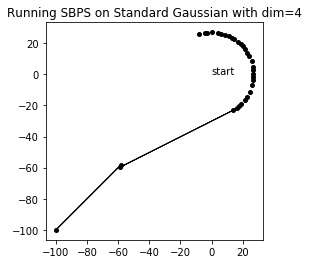

In [59]:
# plotting everything together

gaus_location = np.transpose(x_list)

horizontal = gaus_location[0]
vertical = gaus_location[1]

colors = (0,0,0)
area = (np.pi*10)
num_points = len(horizontal)

# Plot

# plt.imshow(ener_vals_gaus, cmap='YlOrRd', extent=[-3, 3, -3, 3])

# plt.yticks(np.arange(-3, 4, 1))
# plt.xticks(np.arange(-3, 4, 1))
plt.axes().set_aspect('equal')

plt.scatter(horizontal, vertical, s=area/2, c = np.array([[0,0,0]]))    # if this example code is correct, 1st arg is x-axis; 2nd arg is y-axis.
plt.title('Running SBPS on Standard Gaussian with dim=4')

for i in range(0,5):
    plt.arrow(horizontal[i], vertical[i], horizontal[i+1]-horizontal[i], vertical[i+1]-vertical[i], width=0.0001, length_includes_head=True, head_width=0.0001, shape='full')


plt.annotate('start', (0, 0))
    

plt.show()

Observations: it seems to me that both BPS and SBPS will run into this seemingly problematic circular shape of bouncing (if I initialise x0 = (-100,-100) and v0 = (1,1).)--- probably because lambda_ref is set to be small, and exact_gaus_noise_var is also set small, which does not randomising bounce enough. [?]

# Then, try with the Logistic Regression problem with Bernoulli likelihood.

In [88]:

test_input = np.random.normal(0, 5, (100,4))
test_output = np.random.binomial(1, 0.5, 100)

test_dist_logistic_1 = Logistic_Regression_Bern_likelihood(obs_input = test_input, obs_output = test_output, 
                                                           noise_presence = True, subsampling_num = 10, 
                                                           nature_of_noise = 'subsampling')


In [89]:

x_list, v_list, t_list = SBPS(x0 = np.zeros(4), v0 = np.array([1,1,1,1]), Time = 20, lambda_ref = 0.01, 
                              prob_dist = test_dist_logistic_1, delta_t = 0.1, k = 2)


In [98]:
[x.dot(x) for x in v_list]

[4,
 4.0,
 4.000000000000002,
 4.000000000000002,
 4.000000000000002,
 4.000000000000003,
 4.000000000000003,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.0000000000000036,
 4.000000000000003,
 4.000000000000006,
 4.000000000000006,
 4.000000000000007,
 4.000000000000008,
 4.000000000000008,
 4.000000000000007,
 4.000000000000007,
 4.000000000000008,
 4.000000000000008,
 4.000000000000008,
 4.000000000000007,
 4.000000000000007,
 4.000000000000005,
 4.000000000000004,
 4.000000000000005,
 4.000000000000005,
 4.000000000000004,
 4.000000000000005,
 4.000000000000005,
 4.000000000000004,
 4.000000000000005,
 4.000000000000005,
 4.000000000000006,
 4.000000000000006,
 4.000000000000006,
 4.000000000000007,
 4.000000000000007,
 4.000000000000006,
 4.000000000000005,
 4.000000000000005,
 4.000000000000005,
 4.000000000000005,
 4.000000000000005,
 4.0000000000000036,


In [99]:
x_list

[array([0., 0., 0., 0.]),
 array([0.00420879, 0.00420879, 0.00420879, 0.00420879]),
 array([0.04921178, 0.04876407, 0.02593359, 0.03831191]),
 array([0.0376013 , 0.0540848 , 0.02358328, 0.04143074]),
 array([0.02058096, 0.06459343, 0.01603953, 0.05403045]),
 array([-0.00370108,  0.06200914,  0.00651505,  0.06498368]),
 array([-0.0350894 ,  0.0281837 , -0.00090519,  0.0690698 ]),
 array([-0.0812848 , -0.02964131,  0.04536307,  0.11626556]),
 array([-0.0833454 , -0.03139959,  0.0451676 ,  0.11844298]),
 array([-0.083906  , -0.05142532,  0.03830196,  0.12760146]),
 array([-0.07645088, -0.05892349,  0.02921982,  0.12315308]),
 array([ 0.01440366, -0.02836673,  0.09430798,  0.13216485]),
 array([ 0.02579944, -0.02404481,  0.08767579,  0.13218473]),
 array([ 0.03250164, -0.02217412,  0.06545651,  0.13585432]),
 array([0.00862891, 0.00070072, 0.07386673, 0.14052311]),
 array([0.00488028, 0.00171278, 0.07212511, 0.1374032 ]),
 array([0.00617634, 0.0025294 , 0.07314458, 0.13555656]),
 array([0.

In [100]:
len(x_list)

1123

In [102]:
v_list[1122].dot(v_list[1122])

4.000000000000025

This is very weird: in a time period of 20, 1122 bounces occurs! And note that none of them is "refreshment".

# Try with a more well-constructed logistic regression scenario.

First, we fix a true parameter w in R^20. Then, 1000 independent inputs are generated from multivariate standard Gaussian. For each input x_i in R^20, we sample the output label y_i from Bernoulli(1/(1 + exp(-w.dot(x_i)))).

This construction of dataset is nearly the same as the one in experiment 7.1 of SBPS paper.

In [64]:

w = np.random.randint(-5, 6, 20)
obs_input = np.random.multivariate_normal(np.zeros(20), np.identity(20), 1000)

prob_params = 1/(1 + np.exp(-obs_input.dot(w)))

obs_output = np.random.binomial(1, prob_params)


In [65]:

test_dist_logistic_2 = Logistic_Regression_Bern_likelihood(obs_input = obs_input, obs_output = obs_output, 
                                                           noise_presence = True, subsampling_num = 100, 
                                                           nature_of_noise = 'subsampling')


In [67]:

x_list_2, v_list_2, t_list_2 = SBPS(x0 = np.zeros(20), v0 = 0.5*np.ones(20), Time = 20, lambda_ref = 0.01, 
                              prob_dist = test_dist_logistic_2, delta_t = 0.1, k = 3)


In [68]:
print('length of x_list_2: ', len(x_list_2))
print('length of v_list_2: ', len(v_list_2))
print('length of t_list_2: ', len(t_list_2))

length of x_list_2:  82
length of v_list_2:  82
length of t_list_2:  82


The following command verifies that the magnitude of the velocity vector stays the same after bounces.

The test is passed.

In [69]:
verifying_the_velo_magnitude = [x.dot(x) for x in v_list_2]

verifying_the_velo_magnitude

[5.0,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 4.999999999999999,
 5.0,
 5.0,
 5.0,
 5.0,
 4.999999999999999,
 5.0,
 4.999999999999999,
 5.0,
 5.0,
 5.000000000000002,
 5.000000000000002,
 5.000000000000003,
 5.000000000000002,
 5.000000000000003,
 5.000000000000003,
 5.000000000000003,
 5.000000000000002,
 5.000000000000003,
 5.000000000000003,
 5.000000000000003,
 5.000000000000003,
 5.000000000000002,
 5.000000000000002,
 5.000000000000002,
 5.000000000000002,
 5.000000000000003,
 5.000000000000003,
 5.000000000000003,
 5.000000000000003,
 5.000000000000003,
 5.0000000000000036,
 5.0000000000000036,
 5.000000000000004,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.0000000000000036,
 5.000000000000002,
 5.000000000000003,
